In [ ]:
import ROOT
import pandas as pd
import numpy as np
import uproot
import matplotlib.pyplot as plt
import awkward as ak
plt.style.use('science')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn.metrics import accuracy_score
import catboost

Welcome to JupyROOT 6.22/06


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-ahnt4q8b because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [ ]:
mcfile = "/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/preprocess_catboost/MC_3051_0.root"
#datafile = "/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/nSidis/studysmallWithPP/run5032.root"

In [ ]:
# =====================================================
#  GET DATASET FOR MACHINE LEARNING (EITHER MC OR DATA)
# =====================================================
def data(rootfile,version=""):
    assert(version=="data" or version=="mc")
    
    keys = ['flag',
            'nPhotons',
            'nHadrons',
             'gE',
             'gTheta',
             'gPhi',
             'g_pcal_e',
             'g1_pcal_e',
             'g2_pcal_e',
             'g_pcal_du',
             'g_pcal_dv',
             'g_pcal_m2u',
             'g_pcal_m2v',
             'g_pcal_m3u',
             'g_pcal_m3v',
             'g1R',
             'g2R',
             'g1M',
             'g2M',
             'g1dE',
             'g2dE',
             'h1R',
             'h2R',
             'h1M',
             'h2M',
             'h1dE',
             'h2dE',
             'h1q',
             'h2q',
             'eR',
             'eM',
             'edE']
    
    df = pd.DataFrame(columns=keys)
    for batch in uproot.iterate(["{}:PreProcessedEvents".format(rootfile)],library="pd",step_size=1000):
        tmpdf=pd.DataFrame(columns=keys)
        for key in keys:
            tmpdf[key]=batch[key]
        df = pd.concat([df,tmpdf])

    X = df.drop("flag",axis=1)
    if(version=="data"):
        return X
    
    y=df["flag"]
    
    X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.75, random_state=42)
    return X_train, X_validation, y_train, y_validation

In [ ]:
X_train, X_validation, y_train, y_validation = data(mcfile,version="mc")

In [ ]:
best_params={'learning_rate': 0.08400973275335084, 'depth': 3, 'l2_leaf_reg': 4.38, 'boosting_type': 'Plain'}

numeric_train_pool = Pool(X_train, y_train)
numeric_val_pool = Pool(X_validation, y_validation)

model = CatBoostClassifier(**best_params,
                            custom_loss=[metrics.Accuracy()], 
                            random_seed=42,
                            task_type="GPU",
                            devices='0:1')
model.fit(numeric_train_pool, verbose=1, eval_set=numeric_val_pool)

In [556]:
model.save_model("models/test")

In [557]:
from_file = CatBoostClassifier()
from_file.load_model("models/test")

Text(0.5, 1.0, 'ROC Curve')

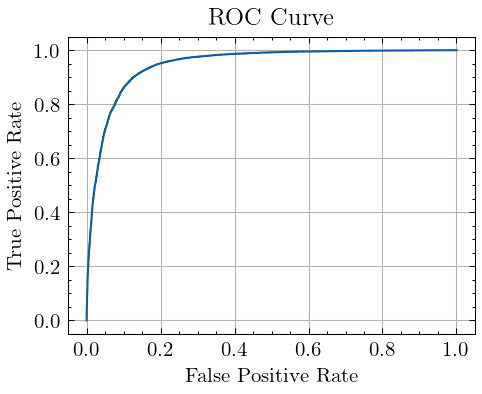

In [566]:
from catboost.utils import get_roc_curve, select_threshold, get_fpr_curve
roc_curve_values=get_roc_curve(model,Pool(X_validation,y_validation))
x=roc_curve_values[0]
y=roc_curve_values[1]
plt.figure(dpi=150)
plt.plot(x,y)
plt.grid()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")

In [567]:
dfPars = pd.DataFrame(data={"Parameter": X_train.columns,"Importance": model.get_feature_importance()})
dfPars.sort_values(by="Importance",ascending=False)

,Parameter,Importance
16,g1M,21.048030
20,h1R,14.305673
5,g_pcal_e,12.334317
17,g2M,9.924563
14,g1R,8.977349
10,g_pcal_m2u,5.571142
11,g_pcal_m2v,3.777195
2,gE,3.463714
15,g2R,3.351388
8,g_pcal_du,1.827898


In [563]:
dfPars.sort_values(by="Importance",ascending=False)["Parameter"][:6].to_list()

['g_pcal_e', 'g1M', 'h1R', 'g1R', 'g_pcal_m2u', 'g2M']

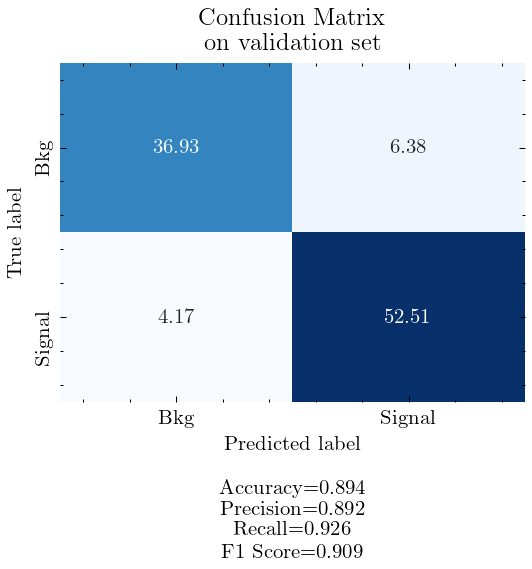

In [564]:
from catboost.utils import get_confusion_matrix
import seaborn as sb
%run ./toolkit/confusion_matrix.ipynb
cm = get_confusion_matrix(model, Pool(X_validation,y_validation))
categories = ['Bkg','Signal']
make_confusion_matrix(cm, 
                      categories=categories,
                      cmap='Blues',
                     cbar=False,
                     figsize=(4,3),
                     count=False,
                     title="Confusion Matrix\n on validation set")